In [1]:
import joblib
import pandas as pd
import truvari
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
data = joblib.load("bp_asm_cov_data.jl")

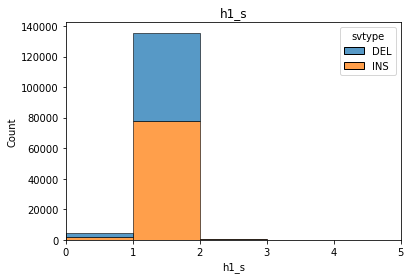

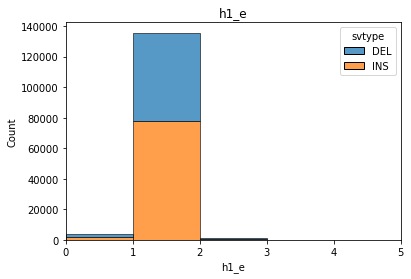

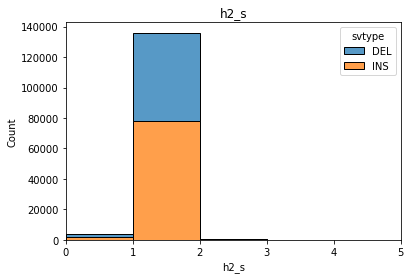

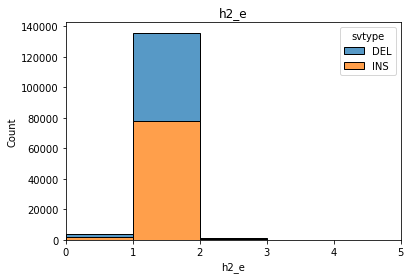

In [13]:
for i in ["h1_s", "h1_e", "h2_s", "h2_e"]:
    p = sb.histplot(data=data.reset_index(), x=i, hue='svtype', multiple="stack", binwidth=1)
    p.set(xlim=(0,5), title=i)
    plt.show()

In [15]:
data.loc[(data["h1_s"] == 1) & (data["h1_e"] == 1), 'h1_status'] = 1
data.loc[(data["h1_s"] == 0) | (data["h1_e"] == 0), 'h1_status'] = 0
data.loc[data["h1_status"].isna(), "h1_status"] = 2

In [16]:
data.loc[(data["h2_s"] == 1) & (data["h2_e"] == 1), 'h2_status'] = 1
data.loc[(data["h2_s"] == 0) | (data["h2_e"] == 0), 'h2_status'] = 0
data.loc[data["h2_status"].isna(), "h2_status"] = 2

<AxesSubplot:xlabel='h1_status', ylabel='count'>

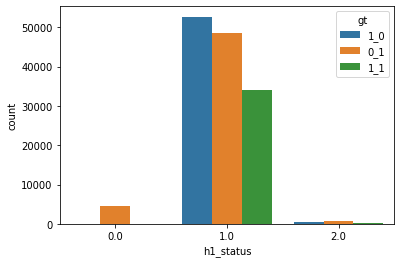

In [37]:
sb.countplot(data=data.reset_index(), x="h1_status", hue="gt")

<AxesSubplot:xlabel='h2_status', ylabel='count'>

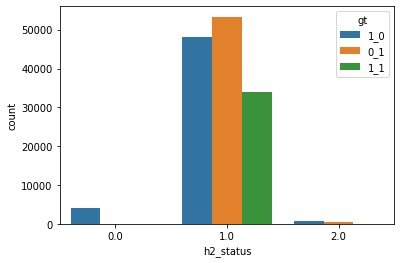

In [38]:
sb.countplot(data=data.reset_index(), x="h2_status", hue="gt")

In [39]:
data.groupby(["h1_status", "h2_status"]).size().unstack()

h2_status,0.0,1.0,2.0
h1_status,,,
0.0,NaN,4369.0,129.0
1.0,3958.0,130279.0,896.0
2.0,120.0,828.0,261.0


In [32]:
data.groupby(["h2_status", "svtype"]).size().unstack()

svtype,DEL,INS
h2_status,,
0.0,1952,2126
1.0,57814,77662
2.0,583,703


In [40]:
data["status"] = None
data.loc[(data["h1_status"] == 1) & (data["h2_status"] == 1), "status"] = "Single"
data.loc[(data["h1_status"] == 2) | (data["h2_status"] == 2), "status"] = "Multi"
data.loc[data["status"].isna(), "status"] = "Half"




[None]

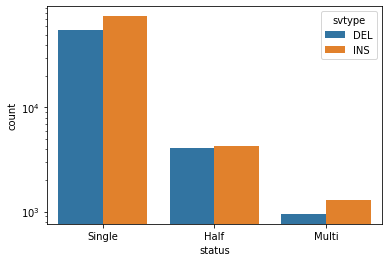

In [41]:
p = sb.countplot(data=data, x="status", hue="svtype")
p.set(yscale="log")

In [119]:
sb.set('poster')

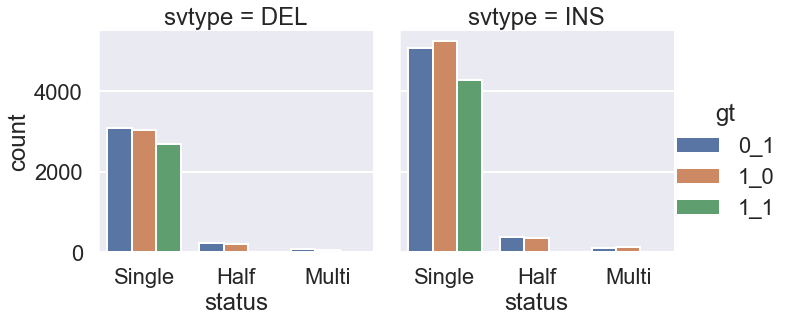

In [121]:
p = sb.catplot(kind="count", col="svtype", 
               data=data[(data["reference"] == 'grch38') & (data["merge"] == 'strict')], 
               x="status", hue="gt", row_order=["exact", "strict", "loose"],
              order=["Single", "Half", "Multi"])
#p.set(yscale="log")

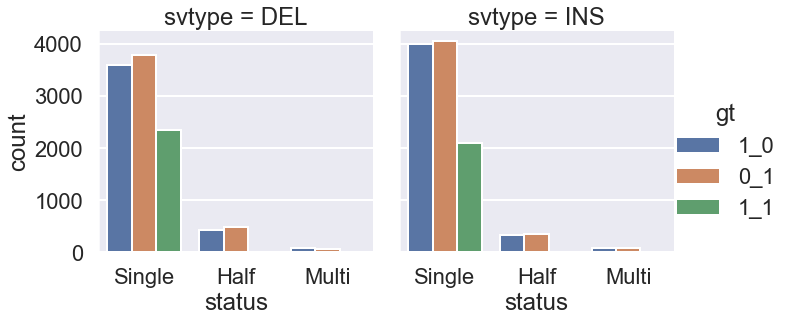

In [122]:
p = sb.catplot(kind="count", col="svtype", 
               data=data[(data["reference"] == 'chm13') & (data["merge"] == 'strict')], 
               x="status", hue="gt", row_order=["exact", "strict", "loose"],
              order=["Single", "Half", "Multi"])
#p.set(yscale="log")

In [64]:
data["keep"] = data["status"] == "Single"
data["Genotype"] = data["gt"].apply(lambda x: truvari.get_gt(x.split('_')).name)

In [66]:
data.groupby(["keep", "Genotype"]).size().unstack()

Genotype,HET,HOM
keep,,
False,10333,228
True,96444,33835


In [68]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(data.groupby(["keep", "Genotype"]).size().unstack())
print(chi2, p)

3019.6790541530136 0.0


In [74]:
data["szbin"] = data["svlen"].apply(truvari.get_sizebin)
data['szbin'] = data['szbin'].astype(truvari.SZBINTYPE)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '[0,50)'),
  Text(1, 0, '[50,100)'),
  Text(2, 0, '[100,200)'),
  Text(3, 0, '[200,300)'),
  Text(4, 0, '[300,400)'),
  Text(5, 0, '[400,600)'),
  Text(6, 0, '[600,800)'),
  Text(7, 0, '[800,1k)'),
  Text(8, 0, '[1k,2.5k)'),
  Text(9, 0, '[2.5k,5k)'),
  Text(10, 0, '>=5k')])

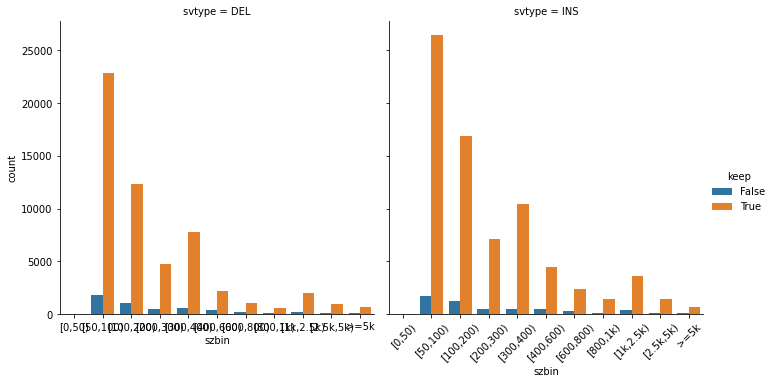

In [84]:
sb.catplot(kind="count", col="svtype", data=data, x="szbin", hue="keep")
plt.xticks(rotation=45)

In [83]:
chi2, p, dof, expected = chi2_contingency(data.groupby(["keep", "szbin"]).size().unstack().T["[50,100)":])
print(chi2, p)

543.100644290411 3.35458191143114e-111


In [82]:
data.groupby(["keep", "szbin"]).size().unstack().T["[50,100)":]

keep,False,True
szbin,,
"[50,100)",3512,49314
"[100,200)",2342,29212
"[200,300)",1014,11886
"[300,400)",1107,18258
"[400,600)",846,6697
"[600,800)",450,3445
"[800,1k)",267,2046
"[1k,2.5k)",621,5631
"[2.5k,5k)",212,2382


Okay, so this is what it looks like for a single sample and doing it properly.  
I need to remake the datastructure with the 'all assemblies' VCF. 

In [87]:
chm13 = joblib.load("del_chm13.strict.sv.jl")
grch38 = joblib.load("del_grch38.strict.sv.jl")

In [96]:
for i in [_ for _ in chm13.columns if _.endswith("_GT")]:
    chm13[i] = chm13[i].apply(lambda x: truvari.get_gt(x).name)

for i in [_ for _ in grch38.columns if _.endswith("_GT")]:
    grch38[i] = grch38[i].apply(lambda x: truvari.get_gt(x).name)

In [124]:
chm13['hap_cov'] = chm13["ASMCOV"].apply(lambda x: (x[0] + x[1]) / 2)
grch38['hap_cov'] = grch38["ASMCOV"].apply(lambda x: (x[0] + x[1]) / 2)

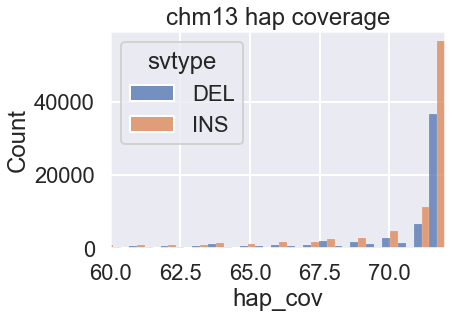

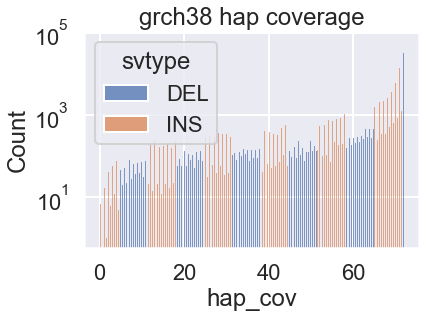

In [147]:
p = sb.histplot(data=chm13, x="hap_cov", hue='svtype', hue_order=["DEL", "INS"], multiple="dodge")
p.set(title="chm13 hap coverage", xlim=(60, 72))
plt.show()
p = sb.histplot(data=grch38, x="hap_cov", hue='svtype', hue_order=["DEL", "INS"], multiple="dodge")
p.set(title="grch38 hap coverage", yscale="log")
plt.show()

In [101]:
chm13['keep'] = chm13["ASMCOV"] == (72, 72)
grch38['keep'] = grch38["ASMCOV"] == (72, 72)

In [150]:
chm13.groupby(["svtype", "keep"]).size().unstack().loc[["DEL", "INS"]]

keep,False,True
svtype,,
DEL,58518,34478
INS,63923,55751


In [151]:
grch38.groupby(["svtype", "keep"]).size().unstack().loc[["DEL", "INS"]]

keep,False,True
svtype,,
DEL,31341,32077
INS,68954,63333


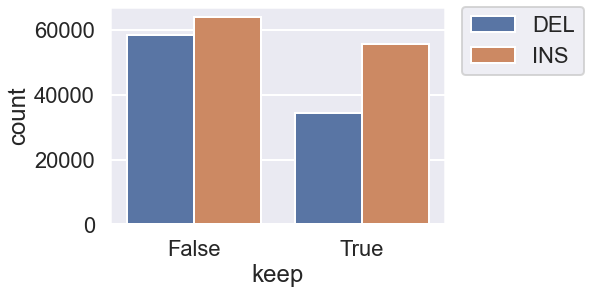

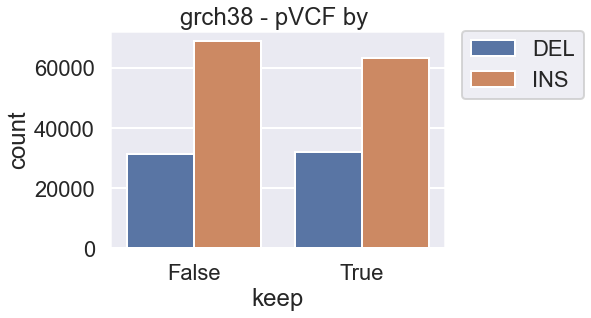

In [136]:
p = sb.countplot(data=chm13, hue="svtype", x="keep", hue_order=["DEL", "INS"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
p = sb.countplot(data=grch38, hue="svtype", x="keep", hue_order=["DEL", "INS"])
p.set(title="grch38 - pVCF by ")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [114]:
gts = [_ for _ in chm13.columns if _.endswith("_GT")]
rows = []
for i in gts:
    j = chm13[i].value_counts()
    rows.append([i, 'all', j.loc["HET"] / j.loc['HOM']])
    j = chm13[chm13["keep"]][i].value_counts()
    rows.append([i, 'keep', j.loc["HET"] / j.loc['HOM']])
    j = chm13[~chm13["keep"]][i].value_counts()
    rows.append([i, 'removed', j.loc["HET"] / j.loc['HOM']])
chm13_ratios = pd.DataFrame(rows, columns=["sample", "state", "ratio"])


In [115]:
gts = [_ for _ in grch38.columns if _.endswith("_GT")]
rows = []
for i in gts:
    j = grch38[i].value_counts()
    rows.append([i, 'all', j.loc["HET"] / j.loc['HOM']])
    j = grch38[grch38["keep"]][i].value_counts()
    rows.append([i, 'keep', j.loc["HET"] / j.loc['HOM']])
    j = grch38[~grch38["keep"]][i].value_counts()
    rows.append([i, 'removed', j.loc["HET"] / j.loc['HOM']])
grch38_ratios = pd.DataFrame(rows, columns=["sample", "state", "ratio"])

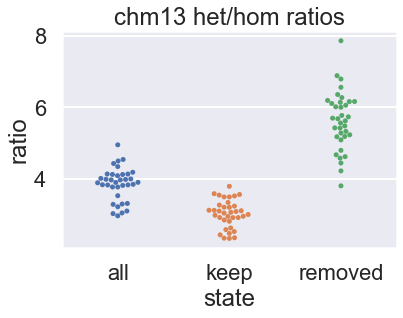

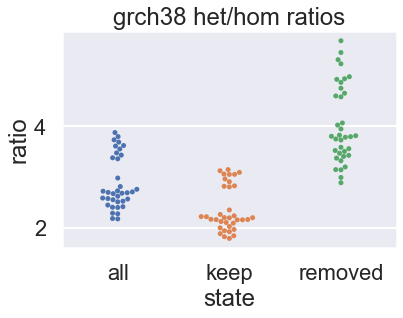

In [152]:
p = sb.swarmplot(data=chm13_ratios, x="state", y="ratio")
p.set(title="chm13 het/hom ratios")
plt.show()

p = sb.swarmplot(data=grch38_ratios, x="state", y="ratio")
p.set(title="grch38 het/hom ratios")
plt.show()

In [159]:
chm13["AC"] = chm13["AC"].apply(lambda x: x[0])
grch38["AC"] = grch38["AC"].apply(lambda x: x[0])

[(0.0, 5.0)]

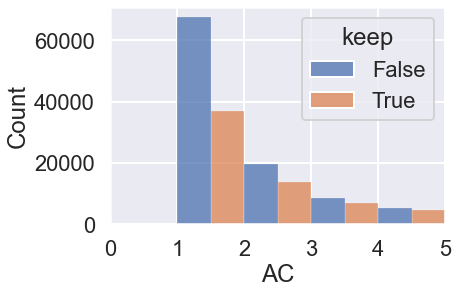

In [166]:
sb.histplot(data=chm13, x="AC", hue="keep", multiple="dodge", binwidth=1).set(xlim=(0,5))

In [170]:
rows = []
for ac, j in chm13.groupby(["AC"]):
    j = j["keep"].value_counts()
    rows.append(['chm13', ac, j[True] / j.sum()])
for ac, j in grch38.groupby(["AC"]):
    j = j["keep"].value_counts()
    rows.append(['grch38', ac, j[True] / j.sum()])
rows = pd.DataFrame(rows, columns=["reference", "AC", "PctKept"])

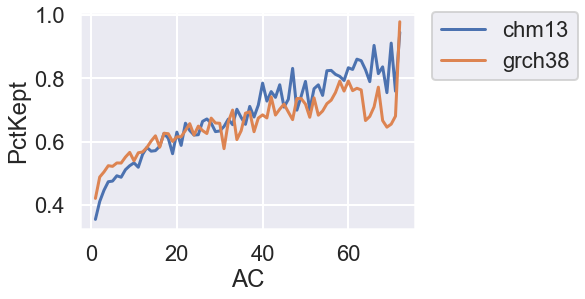

In [172]:
sb.lineplot(data=rows, x="AC", y="PctKept", hue="reference")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [175]:
chm13["keep"].value_counts()

False    122441
True      90229
Name: keep, dtype: int64

In [176]:
90229 / (90229 + 122441)

0.4242676447077632

In [177]:
grch38["keep"].value_counts()

False    100295
True      95410
Name: keep, dtype: int64

In [180]:
(95410 + 90229) / (95410 + 100295 + 90229 + 122441)

0.45457973676155494

In [185]:
data.groupby(["merge", "reference", "status"]).size()

merge   reference  status
exact   chm13      Half       1606
                   Multi       328
                   Single    20660
        grch38     Half       1173
                   Multi       432
                   Single    25158
loose   chm13      Half       1600
                   Multi       318
                   Single    19148
        grch38     Half       1169
                   Multi       415
                   Single    22016
strict  chm13      Half       1606
                   Multi       321
                   Single    19861
        grch38     Half       1173
                   Multi       420
                   Single    23436
dtype: int64

In [191]:
r = []
for i in gts:
    a = chm13.groupby([i, "keep"]).size().unstack().loc[["HET", "HOM"]].sum()
    r.append([i, "chm13", a[True]/a.sum()])
    a = grch38.groupby([i, "keep"]).size().unstack().loc[["HET", "HOM"]].sum()
    r.append([i, "grch38", a[True]/a.sum()])

In [193]:
r = pd.DataFrame(r, columns=["sample", "ref", "kept_pct"])

<AxesSubplot:xlabel='ref', ylabel='kept_pct'>

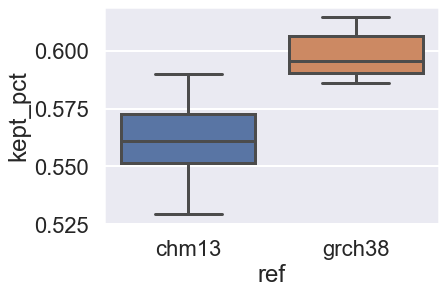

In [194]:
sb.boxplot(data=r, x="ref", y="kept_pct")

In [195]:
r.groupby(['ref'])["kept_pct"].mean()

ref
chm13     0.560463
grch38    0.598241
Name: kept_pct, dtype: float64

In [201]:
view = data.groupby(["sample", "merge", "reference", "status"]).size().unstack()
view['pct'] = view['Single']/ view.sum(axis=1)
view

status                    Half  Multi  Single       pct
sample  merge  reference                               
HG00096 exact  chm13      1606    328   20660  0.914402
               grch38     1173    432   25158  0.940029
        loose  chm13      1600    318   19148  0.908953
               grch38     1169    415   22016  0.932881
        strict chm13      1606    321   19861  0.911557
               grch38     1173    420   23436  0.936354

In [202]:
view.mean()

status
Half       1387.833333
Multi       372.333333
Single    21713.166667
pct           0.924029
dtype: float64